# Calculation of Actor, Genre similarity scores, average user rating & addictiveness score

In [2]:
# for mongodb
import pymongo

# normal stuff
import pandas as pd
import numpy as np
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth', -1)

from collections import defaultdict, Counter
import string
import re
import codecs

# sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Prepare Data

Align the indices of the dramalist scraped info in dramalist_info.pkl to match the indices of the rest of the analysis, so that each show is mapped to a unique index number.

In [3]:
# load dramalist dataframe
df = pickle.load(open('dramalist_info.pkl', 'rb'))

In [4]:
# load pickle order of shows from gensim 
show_order = pickle.load(open('tfidf_files/show_mapping.pkl', 'rb'))

In [5]:
# check if the show indices align
pd.concat([df.showname, show_order], axis=1).head(10)
# the shows indices don't align. Need to align.

,showname,shownames
0,ma boy,ma boy
1,falling for innocence,falling for innocence
2,mad dog,mad dog
3,to the beautiful you,to the beautiful you
4,vampire prosecutor 2,vampire prosecutor 2
5,joseon x-files,joseon x-files
6,beautiful gong shim,beautiful gong shim
7,fashion king,fashion king
8,mysterious il-seung,mysterious il-seung
9,the moon that embraces the sun,reunited worlds


In [6]:
# generate the index to match up
ind = []
for show1 in show_order:
    for i, show2 in enumerate(df.showname):
        if show1 == show2:
#             print show1, i, show2
            ind.append(i)
print ind  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 64, 10, 11, 12, 13, 14, 15, 16, 111, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 274, 43, 44, 45, 46, 47, 48, 82, 50, 51, 318, 53, 54, 55, 56, 57, 58, 353, 60, 30, 62, 63, 9, 372, 66, 67, 68, 69, 352, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 49, 83, 84, 85, 86, 61, 87, 88, 89, 90, 91, 92, 93, 94, 95, 336, 97, 98, 99, 100, 101, 207, 103, 283, 105, 106, 251, 108, 109, 110, 17, 112, 113, 114, 116, 117, 118, 119, 327, 123, 347, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 70, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 120, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 122, 240, 168, 169, 170, 254, 172, 173, 174, 292, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 203, 204, 205, 206, 102, 208, 209, 210, 211, 212, 213, 214, 265, 216, 217, 218, 219, 220, 359, 222,

In [7]:
# pickle the mapping index
pickle.dump(ind, open('show_index_map.pkl', 'wb'))

In [8]:
# align show index
df = df.iloc[ind, :]
df.reset_index(inplace=True)

In [9]:
# check 
pd.concat([df.showname, show_order], axis=1).head(10)
# now it's ok

,showname,shownames
0,ma boy,ma boy
1,falling for innocence,falling for innocence
2,mad dog,mad dog
3,to the beautiful you,to the beautiful you
4,vampire prosecutor 2,vampire prosecutor 2
5,joseon x-files,joseon x-files
6,beautiful gong shim,beautiful gong shim
7,fashion king,fashion king
8,mysterious il-seung,mysterious il-seung
9,reunited worlds,reunited worlds


In [10]:
# add a column for the image map
df['image_index'] = ind
df

,index,actors,aired_date,directors,ep_dur,ep_no,genres,score,screenwriters,showname,synopsis,tags,image_index
0,0,"[Kim So Hyun, Sun Woong, Min Hoo, Hong Yoon Hwa, Kang Hyun Joong, Nam Tae Boo]","Aug 16, 2012 - Aug 30, 2012",NaN,60,3,"[Friendship, Comedy, Romance, School, Youth]",7.5,NaN,ma boy,"Geu Rim is a student at an arts high school who dreams of becoming a pop singer. At school She gets a new roommate, Irene who’s actually a boy. Irena’s persona is a pretty Female CF star and his actual name is Hyun Woo.","[Cross-dressing, Cohabitation, High School, Mini Drama]",0
1,1,"[Kim So Yeon, Jung Kyung Ho, Yoon Hyun Min, Gong Hyun Joo, Jo Eun Ji, Uhm Hyo Sub]","Apr 3, 2015 - May 23, 2015",NaN,60,16,"[Comedy, Romance, Drama, Melodrama]",8.4,NaN,falling for innocence,"Min-Ho's father ran a large company, but his death led to his uncle taking over the company and to Min-Ho's growing into a cutthroat investor. But then his personality changes when the merciless corporate head hunter undergoes a heart transplant surgery. Thanks to his new heart, Min-Ho begins to have warm feelings and he falls in love with a woman named Soon-Jung.","[Love Triangle, Rich Male Lead, Illness, Boy Chases Girl First]",1
2,2,"[Yoo Ji Tae, Woo Do Hwan, Ryu Hwa Young, Jo Jae Yun, Kim Hye Sung, Hong Soo Hyun]","Oct 11, 2017 - Nov 30, 2017",NaN,60,16,"[Thriller, Romance, Crime, Investigation]",8.5,NaN,mad dog,"A realistic drama about the team “Mad Dog”, which catches scam artists that commit insurance fraud.\nThe drama portrays the reality of Korea through diverse insurance crimes that are prevalent in the country. There are the 'copy cats' that imitate and improve the existing crimes, and the 'mad dogs' who catch these bad cats.",NaN,2
3,3,"[Sulli, Choi Min Ho, Lee Hyun Woo, Kim Ji Won, Seo Joon Young, Kang Ha Neul]","Aug 15, 2012 - Oct 4, 2012",[Jun Ki Sang],64,16,"[Comedy, Romance, School, Youth, Drama, Sports]",7.6,NaN,to the beautiful you,"Goo Jae Hee, is a Korean girl who lives in the United States. One day, she sees a track and field competition on TV, and becomes attracted to one of the high jump competitors, Kang Tae Joon. She begins to idolize the young athlete and in order to help him, she disguises herself as a boy and transfers to his all-male high school after he suffered an accident that could potentially end his career.","[Idol, Cross-dressing, Adapted From A Manga, Celebrity, High Jump]",3
4,4,"[Yeon Jung Hoon, Lee Young Ah, Lee Won Jong, Kim Joo Young, Lee Kyung Young, Gong Jung Hwan]","Sep 9, 2012 - Nov 18, 2012",NaN,65,11,"[Action, Mystery, Vampire, Drama, Investigation]",8.5,[Han Jung Hoon],vampire prosecutor 2,"In the second season of “Vampire Prosecutor,” Min Tae Yeon is back as the prosecutor who heads up a new division that investigates unsolved murder cases. No one, except for Detective Hwang Soon Bum, knows that Tae Yeon was bitten seven years ago and acquired vampire powers. Together, they solve murder cases, and each time Tae Yeon uses his “powers” to find leads on cases that seem unsolvable. But the one thinghe can’t solve is: who was the vampire/serial killer that turned him seven years ago? And what happens when Jung In becomes suspicious of Tae Yeon’s “questionable” tactics in solving cases.",NaN,4
5,5,"[Kim Gab Soo, Im Jung Eun, Jo Hee Bong, Kim Ji Hoon, Jun So Min, Jo Jung Eun]","Aug 20, 2010 - Oct 29, 2010",[Kim Heung Dong],45,12,"[Historical, Mystery, Sci-Fi]",7.8,NaN,joseon x-files,"Secret Investigation Record is based on cases detailed in the Annals of Joseon History with a bizarre twist; these incidents incorporate mysterious, supernatural elements that cannot be explained through science. Kim Hyung Do is an inspector of the state whose single-minded focus on his investigations into administrative misdeeds bring him into direct contact with these strange mysteries. Heo Yoon Yi is a government employee who aids him and attempts to understand thesescientific impossibilities with an open mind, in contrast to his cynicism.",

### Extract the Year that Drama was Aired
From the Dramabeans MongoDB database, pull out the year that the drama was aired (based on last aired episode). Append to metadata dataframe.

In [15]:
# "C:\Program Files\MongoDB\Server\3.6\bin\mongod.exe" --dbpath "D:\Documents\Heidi\mongodb\data"

# Connection to Mongo DB
try:
    client = pymongo.MongoClient()
    print "Hooray, we have connected to MongoDB successfully!"
except pymongo.errors.ConnectionFailure, e:
    print "Could not connect to MongoDB: %s" % e 
    
# connect to the dramabeans database
print client.database_names()
db = client.dramabeans_v4

Hooray, we have connected to MongoDB successfully!
[u'admin', u'config', u'dramabeans_v2', u'dramabeans_v3', u'dramabeans_v4', u'local', u'raw_dramabeans']


In [16]:
# extract year
years = []
for show_name in df.showname:
    show = db[show_name].find_one()
    years.append(show['Recap_Time'].year)
df['year'] = years
df    

,index,actors,aired_date,directors,ep_dur,ep_no,genres,score,screenwriters,showname,synopsis,tags,image_index,year
0,0,"[Kim So Hyun, Sun Woong, Min Hoo, Hong Yoon Hwa, Kang Hyun Joong, Nam Tae Boo]","Aug 16, 2012 - Aug 30, 2012",NaN,60,3,"[Friendship, Comedy, Romance, School, Youth]",7.5,NaN,ma boy,"Geu Rim is a student at an arts high school who dreams of becoming a pop singer. At school She gets a new roommate, Irene who’s actually a boy. Irena’s persona is a pretty Female CF star and his actual name is Hyun Woo.","[Cross-dressing, Cohabitation, High School, Mini Drama]",0,2012
1,1,"[Kim So Yeon, Jung Kyung Ho, Yoon Hyun Min, Gong Hyun Joo, Jo Eun Ji, Uhm Hyo Sub]","Apr 3, 2015 - May 23, 2015",NaN,60,16,"[Comedy, Romance, Drama, Melodrama]",8.4,NaN,falling for innocence,"Min-Ho's father ran a large company, but his death led to his uncle taking over the company and to Min-Ho's growing into a cutthroat investor. But then his personality changes when the merciless corporate head hunter undergoes a heart transplant surgery. Thanks to his new heart, Min-Ho begins to have warm feelings and he falls in love with a woman named Soon-Jung.","[Love Triangle, Rich Male Lead, Illness, Boy Chases Girl First]",1,2015
2,2,"[Yoo Ji Tae, Woo Do Hwan, Ryu Hwa Young, Jo Jae Yun, Kim Hye Sung, Hong Soo Hyun]","Oct 11, 2017 - Nov 30, 2017",NaN,60,16,"[Thriller, Romance, Crime, Investigation]",8.5,NaN,mad dog,"A realistic drama about the team “Mad Dog”, which catches scam artists that commit insurance fraud.\nThe drama portrays the reality of Korea through diverse insurance crimes that are prevalent in the country. There are the 'copy cats' that imitate and improve the existing crimes, and the 'mad dogs' who catch these bad cats.",NaN,2,2017
3,3,"[Sulli, Choi Min Ho, Lee Hyun Woo, Kim Ji Won, Seo Joon Young, Kang Ha Neul]","Aug 15, 2012 - Oct 4, 2012",[Jun Ki Sang],64,16,"[Comedy, Romance, School, Youth, Drama, Sports]",7.6,NaN,to the beautiful you,"Goo Jae Hee, is a Korean girl who lives in the United States. One day, she sees a track and field competition on TV, and becomes attracted to one of the high jump competitors, Kang Tae Joon. She begins to idolize the young athlete and in order to help him, she disguises herself as a boy and transfers to his all-male high school after he suffered an accident that could potentially end his career.","[Idol, Cross-dressing, Adapted From A Manga, Celebrity, High Jump]",3,2012
4,4,"[Yeon Jung Hoon, Lee Young Ah, Lee Won Jong, Kim Joo Young, Lee Kyung Young, Gong Jung Hwan]","Sep 9, 2012 - Nov 18, 2012",NaN,65,11,"[Action, Mystery, Vampire, Drama, Investigation]",8.5,[Han Jung Hoon],vampire prosecutor 2,"In the second season of “Vampire Prosecutor,” Min Tae Yeon is back as the prosecutor who heads up a new division that investigates unsolved murder cases. No one, except for Detective Hwang Soon Bum, knows that Tae Yeon was bitten seven years ago and acquired vampire powers. Together, they solve murder cases, and each time Tae Yeon uses his “powers” to find leads on cases that seem unsolvable. But the one thinghe can’t solve is: who was the vampire/serial killer that turned him seven years ago? And what happens when Jung In becomes suspicious of Tae Yeon’s “questionable” tactics in solving cases.",NaN,4,2012
5,5,"[Kim Gab Soo, Im Jung Eun, Jo Hee Bong, Kim Ji Hoon, Jun So Min, Jo Jung Eun]","Aug 20, 2010 - Oct 29, 2010",[Kim Heung Dong],45,12,"[Historical, Mystery, Sci-Fi]",7.8,NaN,joseon x-files,"Secret Investigation Record is based on cases detailed in the Annals of Joseon History with a bizarre twist; these incidents incorporate mysterious, supernatural elements that cannot be explained through science. Kim Hyung Do is an inspector of the state whose single-minded focus on his investigations into administrative misdeeds bring him into direct contact with these strange mysteries. Heo Yoon Yi is a government employee who aids him and attempts to understand thesescientific impossibilities with an open mind, 

### Save ordered data to pickle
So that we can pull it out later...

In [16]:
# save to pickle
pickle.dump(df, open('dramalist_info_ordered.pkl', 'wb'))

In [17]:
print df.shape
df.head(10)

(386, 14)


,index,actors,aired_date,directors,ep_dur,ep_no,genres,score,screenwriters,showname,synopsis,tags,image_index,year
0,0,"[Kim So Hyun, Sun Woong, Min Hoo, Hong Yoon Hwa, Kang Hyun Joong, Nam Tae Boo]","Aug 16, 2012 - Aug 30, 2012",NaN,60,3,"[Friendship, Comedy, Romance, School, Youth]",7.5,NaN,ma boy,"Geu Rim is a student at an arts high school who dreams of becoming a pop singer. At school She gets a new roommate, Irene who’s actually a boy. Irena’s persona is a pretty Female CF star and his actual name is Hyun Woo.","[Cross-dressing, Cohabitation, High School, Mini Drama]",0,2012
1,1,"[Kim So Yeon, Jung Kyung Ho, Yoon Hyun Min, Gong Hyun Joo, Jo Eun Ji, Uhm Hyo Sub]","Apr 3, 2015 - May 23, 2015",NaN,60,16,"[Comedy, Romance, Drama, Melodrama]",8.4,NaN,falling for innocence,"Min-Ho's father ran a large company, but his death led to his uncle taking over the company and to Min-Ho's growing into a cutthroat investor. But then his personality changes when the merciless corporate head hunter undergoes a heart transplant surgery. Thanks to his new heart, Min-Ho begins to have warm feelings and he falls in love with a woman named Soon-Jung.","[Love Triangle, Rich Male Lead, Illness, Boy Chases Girl First]",1,2015
2,2,"[Yoo Ji Tae, Woo Do Hwan, Ryu Hwa Young, Jo Jae Yun, Kim Hye Sung, Hong Soo Hyun]","Oct 11, 2017 - Nov 30, 2017",NaN,60,16,"[Thriller, Romance, Crime, Investigation]",8.5,NaN,mad dog,"A realistic drama about the team “Mad Dog”, which catches scam artists that commit insurance fraud.\nThe drama portrays the reality of Korea through diverse insurance crimes that are prevalent in the country. There are the 'copy cats' that imitate and improve the existing crimes, and the 'mad dogs' who catch these bad cats.",NaN,2,2017
3,3,"[Sulli, Choi Min Ho, Lee Hyun Woo, Kim Ji Won, Seo Joon Young, Kang Ha Neul]","Aug 15, 2012 - Oct 4, 2012",[Jun Ki Sang],64,16,"[Comedy, Romance, School, Youth, Drama, Sports]",7.6,NaN,to the beautiful you,"Goo Jae Hee, is a Korean girl who lives in the United States. One day, she sees a track and field competition on TV, and becomes attracted to one of the high jump competitors, Kang Tae Joon. She begins to idolize the young athlete and in order to help him, she disguises herself as a boy and transfers to his all-male high school after he suffered an accident that could potentially end his career.","[Idol, Cross-dressing, Adapted From A Manga, Celebrity, High Jump]",3,2012
4,4,"[Yeon Jung Hoon, Lee Young Ah, Lee Won Jong, Kim Joo Young, Lee Kyung Young, Gong Jung Hwan]","Sep 9, 2012 - Nov 18, 2012",NaN,65,11,"[Action, Mystery, Vampire, Drama, Investigation]",8.5,[Han Jung Hoon],vampire prosecutor 2,"In the second season of “Vampire Prosecutor,” Min Tae Yeon is back as the prosecutor who heads up a new division that investigates unsolved murder cases. No one, except for Detective Hwang Soon Bum, knows that Tae Yeon was bitten seven years ago and acquired vampire powers. Together, they solve murder cases, and each time Tae Yeon uses his “powers” to find leads on cases that seem unsolvable. But the one thinghe can’t solve is: who was the vampire/serial killer that turned him seven years ago? And what happens when Jung In becomes suspicious of Tae Yeon’s “questionable” tactics in solving cases.",NaN,4,2012
5,5,"[Kim Gab Soo, Im Jung Eun, Jo Hee Bong, Kim Ji Hoon, Jun So Min, Jo Jung Eun]","Aug 20, 2010 - Oct 29, 2010",[Kim Heung Dong],45,12,"[Historical, Mystery, Sci-Fi]",7.8,NaN,joseon x-files,"Secret Investigation Record is based on cases detailed in the Annals of Joseon History with a bizarre twist; these incidents incorporate mysterious, supernatural elements that cannot be explained through science. Kim Hyung Do is an inspector of the state whose single-minded focus on his investigations into administrative misdeeds bring him into direct contact with these strange mysteries. Heo Yoon Yi is a government employee who aids him and attempts to understand thesescientific impossibilities with an open mind, 

# Create similarity matrices
For each feature of interest, create similarity matrices based on pairwise cosine similarity of each show with another.

### Create similarity matrix for actors
#### Steps:
1. One-hot encode the actors for each show, so that the columns are the various actors and the rows are each show. 
2. Calculate cosine similarity 
3. Save to pickle, check that the result is correct

In [13]:
# function to create a unique set
def unique_set(items):
    '''from the input Series, create a unique list of values'''
    unique_set = []
    for item in items:
        if type(item) == list:
            unique_set +=item
    unique_set = list(set(unique_set))
    return unique_set

In [14]:
# function to one-hot encode
def one_hot_encode(series_items, unique_set):
    '''one hot encode for each show based on unique set of actors/genres, etc.
    series_items = series of items to one-hot encode
    return a dataframe with one-hot-encoding'''
    dummies = np.zeros((df.shape[0], len(unique_set)))
    for row, show_items in enumerate(series_items):
        for col, item in enumerate(unique_set):
            if type(show_items) == list:

                if item in show_items:
                    dummies[row, col]= 1
    # convert to dataframe
    dummies_matrix = pd.DataFrame(dummies, columns=unique_set)
    return dummies_matrix

In [15]:
# define a function to create the cosine similarity matrix
def create_cos_sim(num_shows, matrix):
    '''create a cosine similarity matrix of size num_shows * num_shows based on input matrix
    returns the cosine similarity matrix in dataframe format'''
    # create empty matrix
    cos_sim = np.zeros((num_shows, num_shows))

    # calculate cosine similarity for each pair of shows
    for r in range(num_shows):
        for c in range(num_shows):
            x = matrix.iloc[r,:].values.reshape(1, -1)
            y = matrix.iloc[c,:].values.reshape(1, -1)
            cos_sim[r,c] = cosine_similarity(x,y)
    
    # convert into dataframe
    cos_sim_df = pd.DataFrame(cos_sim)
    
    return cos_sim_df

In [35]:
# get unique set of actors from all shows
actors_set = unique_set(df.actors)

# one-hot-encode actor matrix
actor_matrix = one_hot_encode(df.actors, actors_set)

# create cosine similarity matrix
actor_cos_sim = create_cos_sim(df.shape[0], actor_matrix)

# save into pickle
pickle.dump(actor_cos_sim, open('actor_sim.pkl', 'wb'))
pickle.dump(actor_matrix, open('actor_matrix.pkl', 'wb'))

In [17]:
actor_sim = pickle.load(open('actor_sim.pkl', 'rb'))
test = actor_sim[0].sort_values(ascending=False).head(10)
print test

0      1.000000
222    0.166667
93     0.166667
133    0.166667
52     0.166667
41     0.166667
336    0.166667
195    0.166667
130    0.000000
121    0.000000
Name: 0, dtype: float64


In [18]:
# check if this is correct...
print df.showname[test.index[0]], df.actors[test.index[0]]
print df.showname[test.index[1]], df.actors[test.index[1]]
# yes! Kim So Hyun stars in both shows.

ma boy [u'Kim So Hyun', u'Sun Woong', u'Min Hoo', u'Hong Yoon Hwa', u'Kang Hyun Joong', u'Nam Tae Boo']
page turner [u'Kim So Hyun', u'Ji Soo', u'Shin Jae Ha', u'Ye Ji Won', u'Hwang Young Hee', u'Kim Dong Hee']


### Create similarity matrix for genres, tags & year of aired date
#### Steps:
1. One-hot encode the genres and tags for each show, so that the columns are the various genres and tags and the rows are each show. 
2. To the one-hot-encoded matrix, add a column consisting the year that the show was aired, scaled from 0-1 using MinMaxScaler
2. Calculate cosine similarity 
3. Save to pickle, check that the result is correct

In [19]:
# get unique set of genres & tags from all shows
genres_set = unique_set(df.genres)
tags_set = unique_set(df.tags)

# one-hot-encode genres matrix
genres_matrix = one_hot_encode(df.genres, genres_set)
tags_matrix = one_hot_encode(df.tags, tags_set)

In [20]:
# normalise year from 0 to 1
years = df.year.values.reshape(-1,1)
mm = MinMaxScaler()
years_s = pd.Series(mm.fit_transform(years).ravel())

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [38]:
# join the genres, tags & years matrices
comb_matrix = pd.concat([genres_matrix, tags_matrix, years_s], axis=1)

# create cosine similarity matrix
genres_cos_sim = create_cos_sim(df.shape[0], comb_matrix)

# save into pickle
pickle.dump(genres_cos_sim, open('genres_sim.pkl', 'wb'))
pickle.dump(genres_matrix, open('genres_matrix.pkl', 'wb'))
pickle.dump(tags_matrix, open('tags_matrix.pkl', 'wb'))

In [22]:
# check correctness...
test = genres_cos_sim[0].sort_values(ascending=False).head()
print test

0      1.000000
238    0.641870
295    0.604809
284    0.604040
74     0.591883
Name: 0, dtype: float64


In [23]:
print df.showname[test.index[0]], df.genres[test.index[0]], df.tags[test.index[0]], df.year[test.index[0]]
print df.showname[test.index[1]], df.genres[test.index[1]], df.tags[test.index[1]], df.year[test.index[1]]

ma boy [u'Friendship', u'Comedy', u'Romance', u'School', u'Youth'] [u'Cross-dressing', u'Cohabitation', u'High School', u'Mini Drama'] 2012
answer me 1997 [u'Friendship', u'Comedy', u'Romance', u'School', u'Youth'] [u'Gay', u'First Love', u'Childhood Friends', u'Cheerful Girl', u'High School'] 2012


### Average user rating, "Crack" score
#### Average user rating: 
Calculate the average user rating based on the mean of the Dramabeans and Dramalist scores, divide by 10 to scale the score to between 0-1.

#### "Crack" score:
Calculate the addictiveness of the show, aka, the "crack" score, based on the amount of activity generated around a show. This can be measured based on the number of comments that users leave on a particular show. We choose to sum up the number of comments left on the Dramabeans site, and use the log of the sum of comments, scaled using MinMaxScaler to 0-1.

Save as a pickle file.

In [17]:
ratings = df[['showname', 'score']]
ratings.columns= ['showname', 'dramalist_score']

# extract dramabeans' average user score
dramabeans_score = []
for show_name in ratings.showname:
    show = db[show_name].find_one()
    dramabeans_score.append(show['User_Rating'])

In [18]:
dramabeans = pd.DataFrame([float(score)*2 if type(score)== float else np.nan for score in dramabeans_score], columns=['dramabeans_score'])

In [19]:
ratings = pd.concat([ratings, dramabeans], axis=1)
ratings['av_score'] = ratings.dramalist_score + ratings.dramabeans_score
ratings['av_score']= ratings[['dramalist_score', 'dramabeans_score']].mean(axis=1, skipna=True)
ratings['av_score_scaled'] = ratings['av_score'] / 10
ratings.head(10)

,showname,dramalist_score,dramabeans_score,av_score,av_score_scaled
0,ma boy,7.5,8.4,7.95,0.795
1,falling for innocence,8.4,8.0,8.20,0.820
2,mad dog,8.5,9.8,9.15,0.915
3,to the beautiful you,7.6,6.0,6.80,0.680
4,vampire prosecutor 2,8.5,8.0,8.25,0.825
5,joseon x-files,7.8,9.4,8.60,0.860
6,beautiful gong shim,8,7.6,7.80,0.780
7,fashion king,5.6,NaN,5.60,0.560
8,mysterious il-seung,7.7,9.0,8.35,0.835
9,reunited worlds,7.6,8.4,8.00,0.800


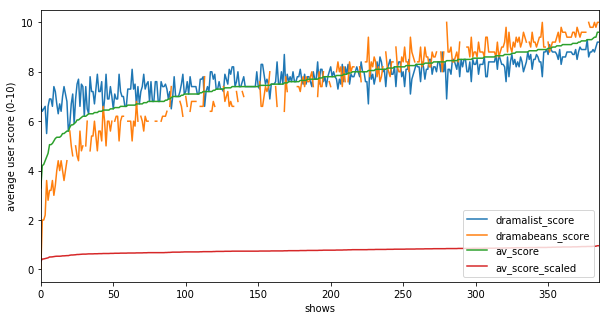

In [20]:
# visualise the difference between dramalist scores and dramabeans scores
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ratings.sort_values('av_score').reset_index(drop=True).plot(ax=ax)
plt.xlabel('shows')
plt.ylabel('average user score (0-10)')
plt.legend(loc='lower right')
plt.show()
# dramabeans scores are more extreme - means that the dramabeans users tend to be more critical than dramalist users

In [21]:
# extract out the number of comments to form the crack score
crack = []
for show_name in ratings.showname:
    num_com = 0
    for show in db[show_name].find():
        num_com += show['Num_Comments']
    crack.append(num_com)
#     dramabeans_score.append(show['User_Rating'])

In [22]:
ratings['crack_raw'] = crack
ratings.head()

,showname,dramalist_score,dramabeans_score,av_score,av_score_scaled,crack_raw
0,ma boy,7.5,8.4,7.95,0.795,273
1,falling for innocence,8.4,8.0,8.20,0.820,1092
2,mad dog,8.5,9.8,9.15,0.915,998
3,to the beautiful you,7.6,6.0,6.80,0.680,1732
4,vampire prosecutor 2,8.5,8.0,8.25,0.825,865


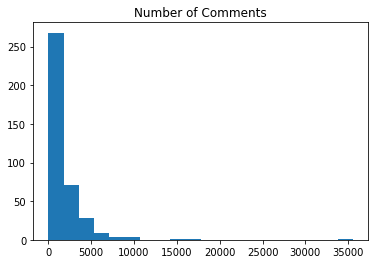

In [23]:
# visualise the log of the number of comments
plt.hist(crack, bins=20)
plt.title('Number of Comments')
plt.show()

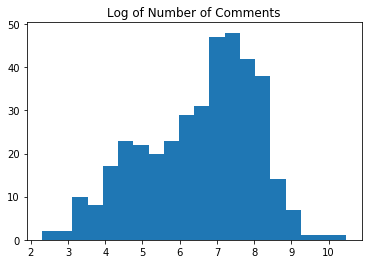

In [24]:
# visualise the log of the number of comments
plt.hist(np.log(crack), bins=20)
plt.title('Log of Number of Comments')
plt.show()

In [32]:
# scale the crack score to between 0 & 10 (to match the average score rating)
crack_s = mm.fit_transform(np.log(crack).reshape(-1,1))
ratings['crack_scaled'] = crack_s
print 'Min: {:0.3}, Max: {:0.3}'.format(ratings.crack_scaled.min(), ratings.crack_scaled.max())
ratings.head(10)

Min: 0.0, Max: 1.0


,showname,dramalist_score,dramabeans_score,av_score,av_score_scaled,crack_raw,crack_scaled
0,ma boy,7.5,8.4,7.95,0.795,273,0.404482
1,falling for innocence,8.4,8.0,8.20,0.820,1092,0.574047
2,mad dog,8.5,9.8,9.15,0.915,998,0.563037
3,to the beautiful you,7.6,6.0,6.80,0.680,1732,0.630467
4,vampire prosecutor 2,8.5,8.0,8.25,0.825,865,0.545543
5,joseon x-files,7.8,9.4,8.60,0.860,517,0.482589
6,beautiful gong shim,8,7.6,7.80,0.780,1295,0.594902
7,fashion king,5.6,NaN,5.60,0.560,223,0.379738
8,mysterious il-seung,7.7,9.0,8.35,0.835,328,0.426932
9,reunited worlds,7.6,8.4,8.00,0.800,1063,0.570755


In [33]:
# pickle
pickle.dump(ratings, open('user_rating.pkl', 'wb'))